In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 
from sklearn.isotonic import IsotonicRegression

In [1]:
pwd

'/home/armstrong/Research/git_repos/patprob/no_duplicates/p_ensemble'

In [30]:
def load_model_results(file_name):
    file = np.load(file_name)
    predictions = file["predictions"]
    targets = file["targets"][:, 0]
    pred_mean = file["prediction_mean"]
    pred_std = file["prediction_std"]
    resids = targets - pred_mean

    return predictions, pred_mean, pred_std, targets, resids

def load_ensemble_predictions(dtype, data_path, trim=True):
    model1_file = f"seed1_128_0.0005_5e-3_0.0002_75_25_20/eval_40/swag_{dtype}_uncertainty_60.npz"
    model2_file = f"seed2_128_0.0005_5e-3_0.0002_75_25_20/eval_40/swag_{dtype}_uncertainty_60.npz"
    model3_file = f"seed3_128_0.0005_5e-3_0.0002_75_25_20/eval_40/swag_{dtype}_uncertainty_60.npz"

    model1_preds, model1_pred_mean, model1_pred_std, model1_targets, model1_resids = load_model_results(model1_file)
    model2_preds, model2_pred_mean, model2_pred_std, model2_targets, model2_resids = load_model_results(model2_file)
    model3_preds, model3_pred_mean, model3_pred_std, model3_targets, model3_resids = load_model_results(model3_file)

    # Join all predictions
    ensemble_predictions = np.concatenate([model1_preds, model2_preds, model3_preds], axis=1)
#     print(ensemble_predictions[0], np.std(ensemble_predictions[0]), ensemble_predictions.shape, ensemble_predictions[0].shape)
    # Get predicted pick and std
    #ensemble_means = np.mean(ensemble_predictions, axis=1)
    if trim:
#         perc5, perc95  = np.percentile(ensemble_predictions, [5, 95], axis=1)
#         trimmed_predictions = np.full((ensemble_predictions.shape[0], int(0.9*ensemble_predictions.shape[1])), np.nan)
#         for i in range(len(ensemble_predictions)):
#             trimmed = ensemble_predictions[i][np.where(np.logical_and(ensemble_predictions[i] > perc5[i], 
#                                                                       ensemble_predictions[i] < perc95[i]))]
#             trimmed_predictions[i, :trimmed.shape[0]] = trimmed
#         ensemble_medians = np.nanmedian(trimmed_predictions, axis=1)
#         ensemble_stds = np.nanstd(trimmed_predictions, axis=1)

        q1, q3  = np.percentile(ensemble_predictions, [25, 75], axis=1)
        iqr = q3 - q1
        if1 = q1 - 1.5*iqr
        if3 = q3 + 1.5*iqr
        ensemble_stds = np.zeros(ensemble_predictions.shape[0])
        ensemble_medians = np.zeros(ensemble_predictions.shape[0])
        for i in range(len(ensemble_predictions)):
            trimmed = ensemble_predictions[i][np.where(np.logical_and(ensemble_predictions[i] > if1[i], 
                                                                      ensemble_predictions[i] < if3[i]))]
            ensemble_stds[i] = np.std(trimmed)
            ensemble_medians[i] = np.median(trimmed)
    else:
        ensemble_medians = np.median(ensemble_predictions, axis=1)
        ensemble_stds = np.std(ensemble_predictions, axis=1)
    # Ensure targets are the same for all three models
    assert np.array_equal(model1_targets, model2_targets)
    assert np.array_equal(model1_targets, model3_targets)
    # Calculate residual stats (actual-predicted)
    #pick_residuals = model1_targets - ensemble_means
    pick_residuals = model1_targets - ensemble_medians
    residual_mean = np.mean(pick_residuals)
    residual_std = np.std(pick_residuals)

    # Combine into a dataframe
    #df_data = {"y_pred":ensemble_means, "std":ensemble_stds, "y_act":model1_targets, "residual":pick_residuals}
    df_data = {"y_pred":ensemble_medians, "std":ensemble_stds, "y_act":model1_targets, "residual":pick_residuals}

    df = pd.DataFrame(data=df_data)
    df.head()

    # read in meta_df
    if dtype=="test":
        dtype="test_fewerhist"
    meta_df = pd.read_csv(f"{data_path}/uuss_{dtype}.csv")

    return df, meta_df

In [31]:
val_df, val_meta_df = load_ensemble_predictions("validation", "../uuss_data/p_resampled")
test_df, test_meta_df = load_ensemble_predictions("test_fewerhist", "../uuss_data/p_resampled")

In [32]:
print("Validation df lengths:", len(val_df), len(val_meta_df))
print("Test df lengths:", len(test_df), len(test_meta_df))
print("Shared evids between datasets?:", np.any(np.isin(test_meta_df.evid.unique(), val_meta_df.evid.unique())))

Validation df lengths: 37476 37476
Test df lengths: 79906 79906
Shared evids between datasets?: False


In [33]:
# Do steps 1 & 2
def eval_cdf(df):
    df["cdf"] = df.apply(lambda x: norm.cdf(x["y_act"], x["y_pred"], x["std"]), axis=1)
    print(df.head())
eval_cdf(val_df)

     y_pred       std  y_act  residual       cdf
0  0.315152  0.028042   0.32  0.004848  0.568627
1  0.146364  0.028169   0.20  0.053636  0.971547
2  0.416521  0.031533   0.43  0.013479  0.665483
3  0.388123  0.068646   0.45  0.061877  0.816309
4  0.245817  0.022109   0.18 -0.065817  0.001456


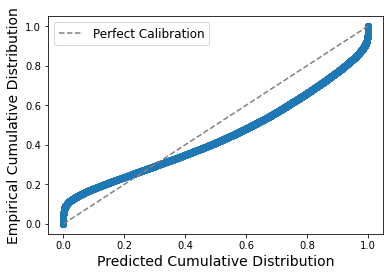

In [35]:
# Do step 3
def plot_empirical_cdf(df, swap_xy=False):
    fig = plt.figure()
    plt.plot(np.arange(0, 1.01, 0.1), np.arange(0, 1.01, 0.1), color="gray", linestyle="--", label="Perfect Calibration")
    if not swap_xy:
        plt.scatter(df.cdf.values, df.p_hat.values, alpha=0.1)
        plt.ylabel("Empirical Cumulative Distribution", fontsize=14)
        plt.xlabel("Predicted Cumulative Distribution", fontsize=14)
    else:
        plt.scatter(df.p_hat.values, df.cdf.values, alpha=0.1)
        plt.xlabel("Empirical Cumulative Distribution", fontsize=14)
        plt.ylabel("Predicted Cumulative Distribution", fontsize=14)
    #plt.title("Estimating Cumulative Density of Forecast", fontsize=16)
    plt.legend(fontsize=12);
    plt.show()
    
def compute_empirical_cdf(df, swap_xy=False):
    p_hat = []
    T = len(df)
    for index, row in df.iterrows():
        p = row["cdf"]
        p_hat.append((df["cdf"] <= p).sum()/T)
    df["p_hat"] = p_hat

    plot_empirical_cdf(df, swap_xy)
compute_empirical_cdf(val_df)

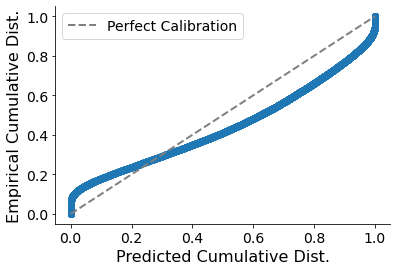

In [40]:
swap_xy=False
fig, ax = plt.subplots()
ax.plot(np.arange(0, 1.01, 0.1), np.arange(0, 1.01, 0.1), color="gray", linestyle="--", linewidth=2, label="Perfect Calibration")
if not swap_xy:
    ax.scatter(val_df.cdf.values, val_df.p_hat.values, alpha=0.1)
    ax.set_ylabel("Empirical Cumulative Dist.", fontsize=16)
    ax.set_xlabel("Predicted Cumulative Dist.", fontsize=16)
else:
    ax.scatter(val_df.p_hat.values, val_df.cdf.values, alpha=0.1)
    ax.set_xlabel("Empirical Cumulative Dist.", fontsize=16)
    ax.set_ylabel("Predicted Cumulative Dist.", fontsize=16)
#plt.title("Estimating Cumulative Density of Forecast", fontsize=16)
ax.legend(fontsize=14);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.show()

In [7]:
def plot_calibration_curve(df, regressor, title, swap_xy=False):
    p_hat_cal = []
    p_hat_uncal = []
    T = len(df)
    for p in np.arange(0, 1.05, 0.05):
        if swap_xy:
            p_hat_cal.append((df.cdf <= regressor.predict([p])[0]).sum()/T)
        else:
            p_hat_cal.append((regressor.predict(df.cdf) <= p).sum()/T)
        
        p_hat_uncal.append((df["cdf"] <= p).sum()/T)

    plt.plot(np.arange(0, 1.05, 0.05), np.arange(0, 1.05, 0.05), color="gray", linestyle="--")
    plt.plot(np.arange(0, 1.05, 0.05), p_hat_cal, marker="o", label="calibrated")
    plt.plot(np.arange(0, 1.05, 0.05), p_hat_uncal, marker="o", label="uncalibrated")
    plt.legend(fontsize=16)
    plt.title(title, fontsize=20, y=1.1)
    plt.ylabel("Empirical CDF", fontsize=20,labelpad=18)
    plt.xlabel("Predicted CDF", fontsize=20, labelpad=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

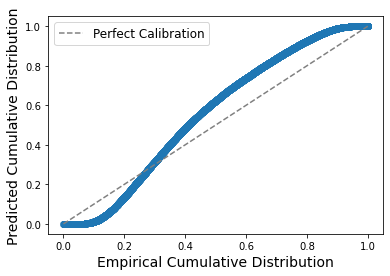

In [8]:
# Inner fence median
plot_empirical_cdf(val_df, swap_xy=True)

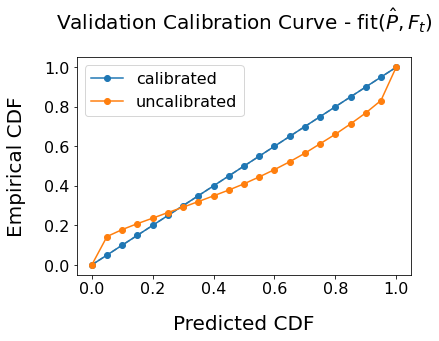

In [9]:
# Fit isotonic regression model to Empirical vs Predicted curve. 
iso_reg_inv = IsotonicRegression().fit(val_df.p_hat.values, val_df.cdf.values)
plot_calibration_curve(val_df, iso_reg_inv, r"Validation Calibration Curve - fit$(\hat{P}, F_t)$", swap_xy=True)

     y_pred       std  y_act  residual       cdf
0  0.293970  0.017291   0.32  0.026030  0.933895
1  0.192086  0.011145   0.20  0.007914  0.761159
2  0.427116  0.024660   0.43  0.002884  0.546558
3  0.475283  0.034338   0.45 -0.025283  0.230771
4  0.134654  0.019223   0.18  0.045346  0.990836


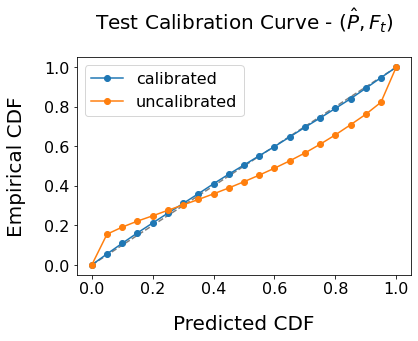

In [10]:
eval_cdf(test_df)
plot_calibration_curve(test_df, iso_reg_inv, r"Test Calibration Curve - $(\hat{P}, F_t)$", swap_xy=True)

In [11]:
lb = 0.16
ub = 0.84

# Transform the lower and upper bounds to be calibrated
lb_transform = iso_reg_inv.transform([lb])[0]
ub_transform = iso_reg_inv.transform([ub])[0]

# Compute the lower and upper bounds for each prediction given the mean and std
test_df["lb_y"] = test_df.apply(lambda x: norm.ppf(lb_transform, x["y_pred"], x["std"]), axis=1)
test_df["ub_y"] = test_df.apply(lambda x: norm.ppf(ub_transform, x["y_pred"], x["std"]), axis=1)

test_df.head()

,y_pred,std,y_act,residual,cdf,lb_y,ub_y
0,0.293970,0.017291,0.32,0.026030,0.933895,0.268538,0.323460
1,0.192086,0.011145,0.20,0.007914,0.761159,0.175694,0.211095
2,0.427116,0.024660,0.43,0.002884,0.546558,0.390845,0.469175
3,0.475283,0.034338,0.45,-0.025283,0.230771,0.424779,0.533847
4,0.134654,0.019223,0.18,0.045346,0.990836,0.106380,0.167440


In [12]:
test_df[(test_df.ub_y - test_df.lb_y) > 0.2]

,y_pred,std,y_act,residual,cdf,lb_y,ub_y
56,0.303912,0.074694,0.33,0.026088,0.636557,0.194050,0.431305
81,-0.177653,0.077876,-0.07,0.107653,0.916571,-0.292194,-0.044833
104,0.274236,0.075033,0.34,0.065764,0.809612,0.163876,0.402208
122,-0.185769,0.067666,-0.27,-0.084231,0.106601,-0.285294,-0.070363
142,0.248501,0.089606,0.48,0.231499,0.995110,0.116706,0.401329
...,...,...,...,...,...,...,...
79781,-0.059756,0.083572,-0.26,-0.200244,0.008286,-0.182675,0.082779
79792,-0.183298,0.088477,0.42,0.603298,1.000000,-0.313433,-0.032396
79805,-0.348920,0.070329,0.17,0.518920,1.000000,-0.452362,-0.228971
79854,0.013746,0.081238,-0.18,-0.193746,0.008542,-0.105741,0.152301


In [44]:
#3061:3062
test_df.iloc[56:57]

,y_pred,std,y_act,residual,cdf,lb_y,ub_y
56,0.303912,0.074694,0.33,0.026088,0.636557,0.19405,0.431305


In [45]:
test_meta_df.iloc[56:57]

,Unnamed: 0,evid,network,station,location,channelz,phase,arrival_time,pick_quality,first_motion,...,event_lon,event_depth,origin_time,magnitude,magnitude_type,rflag,event_type,original_rows,qc_rows,date
56,56,60316447,UU,MSU,1.0,EHZ,P,1.552630e+09,0.5,0,...,-110.947833,3.52,1.552630e+09,1.23,l,F,le,170900,170900,190315.0


In [24]:
model1_file = f"seed1_128_0.0005_5e-3_0.0002_75_25_20/eval_40/swag_test_fewerhist_uncertainty_60.npz"
model2_file = f"seed2_128_0.0005_5e-3_0.0002_75_25_20/eval_40/swag_test_fewerhist_uncertainty_60.npz"
model3_file = f"seed3_128_0.0005_5e-3_0.0002_75_25_20/eval_40/swag_test_fewerhist_uncertainty_60.npz"

model1_preds, model1_pred_mean, model1_pred_std, model1_targets, model1_resids = load_model_results(model1_file)
model2_preds, model2_pred_mean, model2_pred_std, model2_targets, model2_resids = load_model_results(model2_file)
model3_preds, model3_pred_mean, model3_pred_std, model3_targets, model3_resids = load_model_results(model3_file)

In [25]:
import h5py
with h5py.File("../uuss_data/p_resampled/uuss_test_fewerhist_4s_1dup.h5", "r") as f:
    X = f["X"][:]
    Y = f["Y"][:]

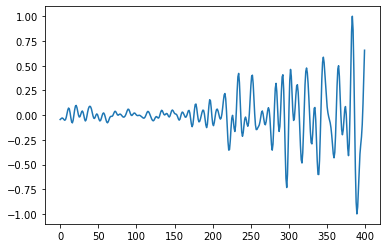

In [51]:
plt.plot(X[81])

193


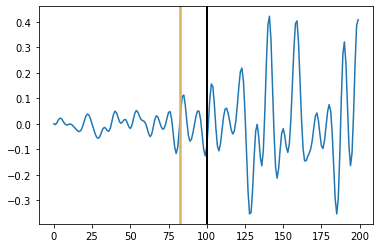

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ind = 81
ppick_sample = 200+round(Y[ind]*100)
print(ppick_sample)
wf = (X[ind]/np.max(abs(X[ind])))[ppick_sample-100:ppick_sample+100]
plt.plot(wf)
ax.axvline(100+test_df.iloc[ind].y_pred*100, color="#d8b365", label="P_corr", linewidth=2.5)
ax.axvline(100, color="k", linestyle="-", label="P_est", linewidth=2)

# shifted_m1_preds = model1_preds[ind] - ppick_sample
# shifted_m2_preds = model2_preds[ind] - ppick_sample
# shifted_m3_preds = model3_preds[ind] - ppick_sample

# preds = [shifted_m1_preds, shifted_m2_preds, shifted_m3_preds]
# colors = ["#5ab4ac", "#c7eae5", "#01665e"]
# bins = ax.hist(preds, bins=np.arange(ppick_sample-25,ppick_sample+25,1), stacked=True, density = True, 
#                alpha=1.0, edgecolor="black", linewidth=0.7, label=["m1", "m2", "m3"], 
#                color=colors)
# max_dens = np.max(bins[0])

# ax.axvline(ppick_sample, color="k", linestyle="-", label="P_est", linewidth=2)
# # ax.axvline(2.0+p_corr, color="#d8b365", label="P_corr", linewidth=2.5)
# # ax.axvline(2.0+window_ats.iloc[0].pick_lb, color="k", linestyle="--", label="CI", linewidth=2.5)
# # ax.axvline(2.0+window_ats.iloc[0].pick_ub, color="k", linestyle="--", linewidth=2.5)
# wf_norm = max_dens/np.max(abs(wf))
# ax.plot(np.arange(ppick_sample-25,ppick_sample+25,1), wf*wf_norm, color="slategray", linewidth=2)
# #ax.axvline(2.0+(puuss_at_secs - pauto_at_secs)[0], label="P_uuss", linewidth=2, color="#8c510a")

# # plt.plot(np.arange(0, n*0.01, 0.01), plot_sproba-1.5, color="C1", label="S")
# # plt.plot(np.arange(0, n*0.01, 0.01), plot_sproba-3, color="C1")
# ax.axes.get_yaxis().set_visible(False)
# ax.get_xaxis().tick_bottom()
# ax.legend(fontsize=12, ncol=2, borderpad=0.2, columnspacing=0.8, loc="upper left")
# ax.tick_params(labelsize=18)
# ax.set_xlabel("Seconds", size=20)
# plt.text(0.06, 0.15, "HHZ", transform=ax.transAxes, fontsize=20)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)

In [35]:
max_dens

nan

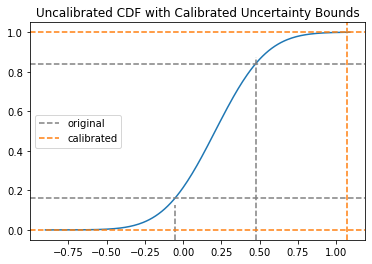

In [13]:
lb = 0.16
ub = 0.84

x = np.arange(-0.9, 1.1, 0.01)
mu = test_df.iloc[3061].y_pred
sigma = test_df.iloc[3061]["std"]

plt.plot(x, norm.cdf(x, mu, sigma))
plt.axvline(norm.ppf(lb, mu, sigma), ymax=lb, linestyle="--", color="gray", label="original")
plt.axhline(lb, linestyle="--",  color="gray")

plt.axvline(norm.ppf(ub, mu, sigma), ymax=ub, linestyle="--", color="gray")
plt.axhline(ub, linestyle="--",  color="gray")

lb = iso_reg_inv.transform([0.05])[0]
lb_x = norm.ppf(lb, mu, sigma)
plt.axvline(lb_x, ymax=lb, linestyle="--", color="C1", label="calibrated")
plt.axhline(lb, linestyle="--",  color="C1")
ub = iso_reg_inv.transform([0.95])[0]
ub_x = norm.ppf(ub, mu, sigma)
plt.axvline(ub_x, ymax=ub, linestyle="--", color="C1")
plt.axhline(ub, linestyle="--",  color="C1")
plt.legend()

plt.title("Uncalibrated CDF with Calibrated Uncertainty Bounds");

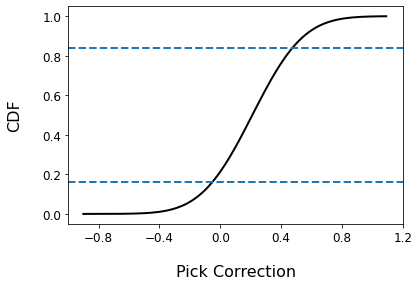

In [14]:
lb = 0.16
ub = 0.84

x = np.arange(-0.9, 1.1, 0.01)
mu = test_df.iloc[3061].y_pred
sigma = test_df.iloc[3061]["std"]

plt.plot(x, norm.cdf(x, mu, sigma), color="k",  linewidth=2)
plt.axhline(lb, linestyle="--",  color="tab:blue",  linewidth=2)
plt.axhline(ub, linestyle="--",  color="tab:blue",  linewidth=2)
# plt.scatter(norm.ppf(lb, mu, sigma), lb, color="red", zorder=0)
# plt.scatter(norm.ppf(ub, mu, sigma), ub, color="red", zorder=0)

# plt.axhline(lb_transform, linestyle="--",  color="gray")
# plt.axhline(ub_transform, linestyle="--",  color="gray")
# plt.scatter(norm.ppf(lb_transform, mu, sigma), lb_transform, color="red", zorder=0)
# plt.scatter(norm.ppf(ub_transform, mu, sigma), ub_transform, color="red", zorder=0)

plt.ylabel("CDF", fontsize=16, labelpad=20)
plt.xlabel("Pick Correction", fontsize=16, labelpad=20)
plt.xticks(np.arange(-0.8, 1.3, 0.4), fontsize=12);
plt.yticks(fontsize=12);

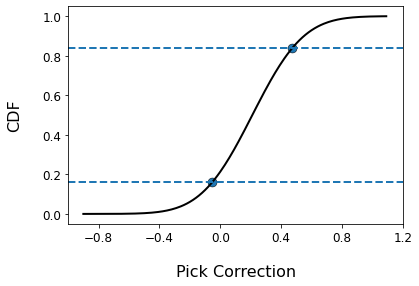

In [15]:
plt.plot(x, norm.cdf(x, mu, sigma), color="k",  linewidth=2)
plt.axhline(lb, linestyle="--",  color="tab:blue",  linewidth=2)
plt.axhline(ub, linestyle="--",  color="tab:blue",  linewidth=2)
plt.scatter(norm.ppf(lb, mu, sigma), lb, color="tab:blue", zorder=0, edgecolor="k", linewidth=0.5, s=80)
plt.scatter(norm.ppf(ub, mu, sigma), ub, color="tab:blue", zorder=0, edgecolor="k", linewidth=0.5, s=80)

# plt.axhline(lb_transform, linestyle="--",  color="gray")
# plt.axhline(ub_transform, linestyle="--",  color="gray")
# plt.scatter(norm.ppf(lb_transform, mu, sigma), lb_transform, color="red", zorder=0)
# plt.scatter(norm.ppf(ub_transform, mu, sigma), ub_transform, color="red", zorder=0)

plt.ylabel("CDF", fontsize=16, labelpad=20)
plt.xlabel("Pick Correction", fontsize=16, labelpad=20)
plt.xticks(np.arange(-0.8, 1.3, 0.4), fontsize=12);
plt.yticks(fontsize=12);

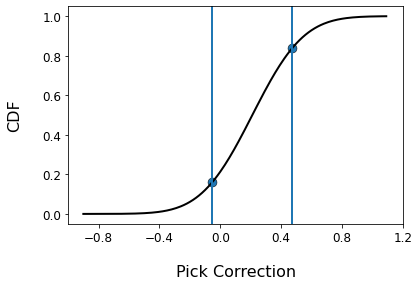

In [16]:
plt.plot(x, norm.cdf(x, mu, sigma), color="k",  linewidth=2)
plt.axvline(norm.ppf(lb, mu, sigma),  color="tab:blue",  linewidth=2)
plt.axvline(norm.ppf(ub, mu, sigma),  color="tab:blue",  linewidth=2)
plt.scatter(norm.ppf(lb, mu, sigma), lb, color="tab:blue", zorder=0, edgecolor="k", linewidth=0.5, s=80)
plt.scatter(norm.ppf(ub, mu, sigma), ub, color="tab:blue", zorder=0, edgecolor="k", linewidth=0.5, s=80)

# plt.axhline(lb_transform, linestyle="--",  color="gray")
# plt.axhline(ub_transform, linestyle="--",  color="gray")
# plt.scatter(norm.ppf(lb_transform, mu, sigma), lb_transform, color="red", zorder=0)
# plt.scatter(norm.ppf(ub_transform, mu, sigma), ub_transform, color="red", zorder=0)

plt.ylabel("CDF", fontsize=16, labelpad=20)
plt.xlabel("Pick Correction", fontsize=16, labelpad=20)
plt.xticks(np.arange(-0.8, 1.3, 0.4), fontsize=12);
plt.yticks(fontsize=12);

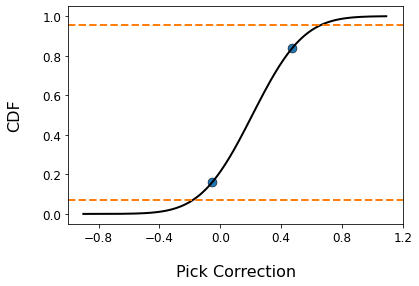

In [17]:
plt.plot(x, norm.cdf(x, mu, sigma), color="k",  linewidth=2)

plt.scatter(norm.ppf(lb, mu, sigma), lb, color="tab:blue", zorder=0, edgecolor="k", linewidth=0.5, s=80)
plt.scatter(norm.ppf(ub, mu, sigma), ub, color="tab:blue", zorder=0, edgecolor="k", linewidth=0.5, s=80)

plt.axhline(lb_transform, linestyle="--",  color="tab:orange",  linewidth=2)
plt.axhline(ub_transform, linestyle="--",  color="tab:orange",  linewidth=2)
# plt.scatter(norm.ppf(lb_transform, mu, sigma), lb_transform, color="red", zorder=0)
# plt.scatter(norm.ppf(ub_transform, mu, sigma), ub_transform, color="red", zorder=0)

plt.ylabel("CDF", fontsize=16, labelpad=20)
plt.xlabel("Pick Correction", fontsize=16, labelpad=20)
plt.xticks(np.arange(-0.8, 1.3, 0.4), fontsize=12);
plt.yticks(fontsize=12);

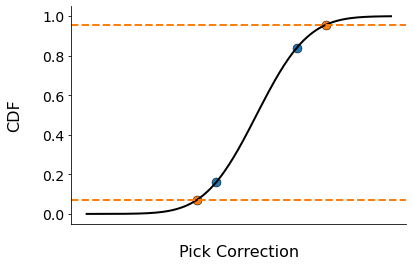

In [27]:
fig, ax = plt.subplots()

ax.plot(x, norm.cdf(x, mu, sigma), color="k",  linewidth=2)

ax.scatter(norm.ppf(lb, mu, sigma), lb, color="tab:blue", zorder=0, edgecolor="k", linewidth=0.5, s=80)
ax.scatter(norm.ppf(ub, mu, sigma), ub, color="tab:blue", zorder=0, edgecolor="k", linewidth=0.5, s=80)

ax.axhline(lb_transform, linestyle="--",  color="tab:orange",  linewidth=2)
ax.axhline(ub_transform, linestyle="--",  color="tab:orange",  linewidth=2)
ax.scatter(norm.ppf(lb_transform, mu, sigma), lb_transform, color="tab:orange", zorder=0, 
            edgecolor="k", linewidth=0.5, s=80)
ax.scatter(norm.ppf(ub_transform, mu, sigma), ub_transform, color="tab:orange", zorder=0, 
            edgecolor="k", linewidth=0.5, s=80)

ax.set_ylabel("CDF", fontsize=16, labelpad=20)
ax.set_xlabel("Pick Correction", fontsize=16, labelpad=20)
#ax.set_xticks(np.arange(-0.8, 1.3, 0.4), fontsize=12);
#ax.set_yticks(fontsize=12);
ax.set_xticks([])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)

#fig.savefig("CDF_calibration_ex1.png")

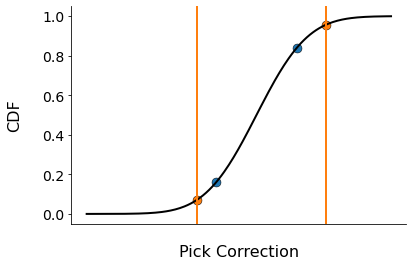

In [28]:
fig, ax = plt.subplots()

ax.plot(x, norm.cdf(x, mu, sigma), color="k",  linewidth=2)

ax.scatter(norm.ppf(lb, mu, sigma), lb, color="tab:blue", zorder=0, edgecolor="k", linewidth=0.5, s=80)
ax.scatter(norm.ppf(ub, mu, sigma), ub, color="tab:blue", zorder=0, edgecolor="k", linewidth=0.5, s=80)

ax.axvline(norm.ppf(lb_transform, mu, sigma),  color="tab:orange",  linewidth=2)
ax.axvline(norm.ppf(ub_transform, mu, sigma),  color="tab:orange",  linewidth=2)
ax.scatter(norm.ppf(lb_transform, mu, sigma), lb_transform, color="tab:orange", zorder=0, 
            edgecolor="k", linewidth=0.5, s=80)
ax.scatter(norm.ppf(ub_transform, mu, sigma), ub_transform, color="tab:orange", zorder=0, 
            edgecolor="k", linewidth=0.5, s=80)

ax.set_ylabel("CDF", fontsize=16, labelpad=20)
ax.set_xlabel("Pick Correction", fontsize=16, labelpad=20)
#ax.set_xticks(np.arange(-0.8, 1.3, 0.4), fontsize=12);
#ax.set_yticks(fontsize=12);
ax.set_xticks([])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)

#fig.savefig("CDF_calibration_ex1.png")

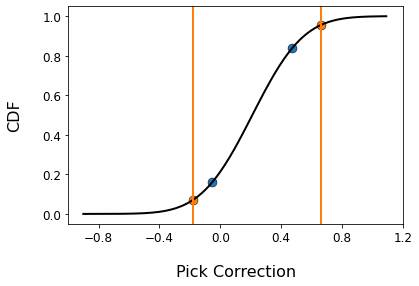

In [66]:
plt.plot(x, norm.cdf(x, mu, sigma), color="k",  linewidth=2)

plt.scatter(norm.ppf(lb, mu, sigma), lb, color="tab:blue", zorder=0, edgecolor="k", linewidth=0.5, s=80)
plt.scatter(norm.ppf(ub, mu, sigma), ub, color="tab:blue", zorder=0, edgecolor="k", linewidth=0.5, s=80)

plt.axvline(norm.ppf(lb_transform, mu, sigma),  color="tab:orange",  linewidth=2)
plt.axvline(norm.ppf(ub_transform, mu, sigma),  color="tab:orange",  linewidth=2)
plt.scatter(norm.ppf(lb_transform, mu, sigma), lb_transform, color="tab:orange", zorder=0, 
            edgecolor="k", linewidth=0.5, s=80)
plt.scatter(norm.ppf(ub_transform, mu, sigma), ub_transform, color="tab:orange", zorder=0, 
            edgecolor="k", linewidth=0.5, s=80)

plt.ylabel("CDF", fontsize=16, labelpad=20)
plt.xlabel("Pick Correction", fontsize=16, labelpad=20)
plt.xticks(np.arange(-0.8, 1.3, 0.4), fontsize=12);
plt.yticks(fontsize=12);
fig.savefig("CDF_calibration_ex2.png")

In [67]:
ub_transform

0.9559536145895293

In [68]:
lb_transform

0.07066940318143151

In [ ]:
# Would use other paramaterization if wanted to say what percentage of data are within bounds